# MNIST training example

This notebook presents a full commented implementation of the jacobian optimization method introduced in [1][Relative gradient optimization of the Jacobian term in unsupervised deep learning](https://arxiv.org/pdf/2006.15090.pdf)

## Imports

The method has been implemented using Python and [PyTorch](https://pytorch.org/).

In [1]:
import torch               as t
import torch.nn            as nn
import torch.nn.functional as F
import torch.autograd      as ad
import torch.optim         as optim

import time

from utils import shuffle_perm, batchify


## Hyperparameters

In [2]:
n_layers   = 2
lr         = 1e-4
n_epochs   = 10
batch_size = 10

log_every  = 1

## Loading the training dataset

We load the MNIST training and validation datasets as simple matrices of size NxD where N will usually be the `batch_size` and D = 784 (MNIST flattened dimensionality). As the first dimension is the batch dimension, we assume the samples to be arranged by rows.

In [3]:
import sys
sys.path.append('experiments/')
from datasets.dataloaders import load_dataset
x, val_data, _, _ = load_dataset("MNIST")

x = t.from_numpy(x).float()
val_data = t.from_numpy(val_data).float()

## Model definition

We implement the `smooth_leaky_relu` activation function
$s_L(x) = \alpha x + (1 - \alpha) \log (1 + e^x)$ and the `Dense` fully-connected network we use. The need for the intermediate activations and the `delta` terms is detailed in Section 4 of [[1]](https://arxiv.org/pdf/2006.15090.pdf).

In [4]:
def smooth_leaky_relu(x, alpha=0.3):
    """Smoothed version of the leaky relu activation function
    Inspiration:
    https://stats.stackexchange.com/questions/329776/approximating-leaky-relu-with-a-differentiable-function
    """
    return alpha*x + (1 - alpha)*(t.logaddexp(x, t.zeros(x.shape)))

class DenseNet(nn.Module):

    def __init__(self, D,
                 n_layers=2,
                 nonlinearity=smooth_leaky_relu,
                 init=nn.init.orthogonal_):

        super(DenseNet, self).__init__()

        self.nonlinearity = nonlinearity
        self.D = D
        self.linear_layers = nn.ModuleList()
        self.activations = []

        for _ in range(n_layers):
            layer = nn.Linear(D, D)
            init(layer.weight)
            nn.init.zeros_(layer.bias)
            self.linear_layers.append(layer)

    # Forward pass through the network.
    # Returns the latent configurations `z` (output)
    # and saves the activations at intermediate layers `ys`.
    def forward(self, x):

        self.activations = []
        z = nn.Flatten()(x)

        for layer in self.linear_layers[:-1]:
            y = layer(z)
            self.activations.append(y)
            z = self.nonlinearity(y)

        # last layer (no nonlinearity)
        z = self.linear_layers[-1](z)

        # grads of activations/output represent the 'delta' terms
        # (the backpropagated error)
        for y in self.activations:
            y.retain_grad()
        z.retain_grad()

        return z

    def get_activations(self):
        return self.activations
    
D = x.shape[-1]
model = DenseNet(D)

## Loss function

The objective function to optimize is the loglikelihood of our model $\boldsymbol{L}(\boldsymbol{x}) = \log p_{\boldsymbol{\theta}}(\boldsymbol{x})$ that we rewrite as $\boldsymbol{L}(\boldsymbol{x}) = \boldsymbol{L}_p(\boldsymbol{x}) + \boldsymbol{L}_J(\boldsymbol{x})$ with

$$
\boldsymbol{L}_p (\boldsymbol{x}) = \sum_i \log p_i(\boldsymbol{g}^i_{\boldsymbol{\theta}}(\boldsymbol{x})) ; \enspace \ \boldsymbol{L}_J (\boldsymbol{x}) = \log \left|\det \boldsymbol{J}\boldsymbol{g}_{\boldsymbol{\theta}}(\boldsymbol{x})\right|\,, 
$$

We further separate $\boldsymbol{L}_J$ in a "layerwise" component $\boldsymbol{L}_J^1$ depending on the intermediate layers activations $\boldsymbol{y}_k$ and a component $\boldsymbol{L}_J^2$ depending on the parameters only

$$
\begin{align}
 \boldsymbol{L}_J (\boldsymbol{z}_{k-1}) &= \sum_{i=1}^D\log \left| \sigma'(y_{k}^{i}) \right| + \log \left| \det \boldsymbol{W}_k \right| \\
    &=: \boldsymbol{L}_J^{1}(\boldsymbol{y}_{k}) + \boldsymbol{L}_J^{2}(\boldsymbol{z}_{k-1})\,.
\end{align}
$$

The gradient of the $\boldsymbol{L}_J^2$ term is calculated explicitly and can be computed efficiently by making use of the relative gradient trick (see Section 4 of [[1]](https://arxiv.org/pdf/2006.15090.pdf)). Through automatic differentiation we optimize the latent variables distribution of choice $\boldsymbol{L}_p$ (a standard Gaussian in this case) and the `loss_layerwise` term $\boldsymbol{L}_J^1$.

In [5]:
log_pdf = t.distributions.MultivariateNormal(t.zeros(D), t.eye(D)).log_prob

def loss_layerwise(f):
    
    def g(x):
        y = f(x)

        # we need to backprop through this computation,
        # hence `create_graph=True`;
        # also, `grad()` returns a tuple that we need to unpack
        dfdx = ad.grad(y, x, t.ones_like(x), create_graph=True)[0]
        log_dfdx = t.log(dfdx)

        # summing over dimensions
        return t.sum(log_dfdx, axis=-1)
    
    return g

def loss(model, x):
    z = model(x)
    ys = t.stack(model.get_activations())

    lpdf = log_pdf(z)
    lwise = loss_layerwise(model.nonlinearity)(ys)

    # note: we minimize the negative of the LL -> maximize the LL
    return - t.mean(lpdf) - t.mean(lwise), z

# Function to compute the term L^2_J of the loglikelihood
def log_abs_det(model):
    p = list(model.parameters())
    ldet = sum([t.slogdet(W)[1] for W in p[::2]])

    return ldet

# Note that here we want to log the full loglikelihood;
# during training we directly optimize only the term `lp + l_j^1`
# and we include the gradient of the term `l_j^2` explicitly
# (i.e. the `loss` function we derive includes only `lp + l_j^1`
# and the `l_j^2` term is introduced with `add_det_grad`)
def full_loss(model, x):
    l1, z = loss(model, x)
    l2 = log_abs_det(model)

    return l2 - l1

## Relative gradient

Here we implement the functions to compute the relative gradient, applying the relative trick and taking care of avoiding matrix-matrix multiplications as described in Section 4 of [[1]](https://arxiv.org/pdf/2006.15090.pdf).

The core of the computation happens in the `apply_trick` function, where the updates are computed following Appendix F of [[1]](https://arxiv.org/pdf/2006.15090.pdf) to include biases (note that we transposed the update expressions as we are working with row vectors).

The `add_det_grad` function completes the gradient updates by including the gradients of the $\boldsymbol{L}_J^2$ term of the loglikelihood, that we compute explicitly.

In [6]:
def apply_trick(Wb, z, bp_terms):
    W, b = Wb

    # note that the nn.Linear layer in PyTorch performs the operation
    # `y = xW^T + b`, so here we exchange the transposition to adhere
    # to the notation in [1]
    W = W.T

    db, delta = bp_terms
    dW = t.mm(t.mm(W, t.mm(W.T, z.T)), delta) + t.outer(t.mv(W, b), db)
    db = db * (1 + t.dot(b, b.T)) + t.mv(delta.T, t.mv(z, t.mv(W, b)))

    # back to "PyTorch notation"
    dW = dW.T

    return dW, db

def add_det_grad(W):
    return W.grad - W

def compute_relative_gradient(model, x, z):
    layers = model.linear_layers
    ys = model.get_activations()

    # collecting the backprop errors `deltas`
    deltas = [y.grad for y in ys] + [z.grad]

    # collecting intermediate activations + nonlinearity
    zs = [x] + [model.nonlinearity(y) for y in ys]

    for (z, delta, layer) in zip(zs, deltas, layers):

        W, b = list(layer.parameters())
        dW, db = W.grad, b.grad

        dW, db = apply_trick((W, b), z, (db, delta))

        # update gradients
        W.grad = dW
        b.grad = db

        dW = add_det_grad(W)

        # update gradients
        W.grad = dW

## Logging

Here we define a list of `loggers` to log scalar values. Each logger must be a function taking arguments `model` and `epoch` and must return a tuple: the first element is a string indicating the name of the logged quantity, the second element is the value to log. We define in this way a function `log_loss` to log the loglikelihood on the validation set during training, and a `log_time` function to log the execution time of each epoch.

In [7]:
def get_loss_logger():
    loss_vs_time = []

    def log_loss(model, epoch):
        val_loss = full_loss(model, val_data)
        loss_vs_time.append(val_loss)
        return "Loglikelihood", val_loss

    return log_loss, lambda: loss_vs_time

log_loss, get_loss_vs_time = get_loss_logger()

def timer():
    start = time.perf_counter()

    def log_time(model, epoch):
        nonlocal start
        now = time.perf_counter()
        delta = now - start
        start = now
        return "Time", delta

    return log_time

loggers = [log_loss, timer()]

## Training loop with Adam optimizer

Here we define a standard training loop using Adam with default parameters. After the backward pass we can use the accumulated gradients to compute the relative gradient of the parameters (using the `compute_relative_gradient` function previously defined).

In [9]:
optimizer = optim.Adam(model.parameters(), lr=lr)

for i in range(1, n_epochs + 1):

    # TODO: shuffle in-place to reduce memory allocations (first, copy data)
    x, _ = shuffle_perm(x)
    batches = batchify(x, batch_size)

    for batch in batches:

        # zero the parameter gradients
        optimizer.zero_grad()

        l, z = loss(model, batch)
        l.backward()

        compute_relative_gradient(model, batch, z)

        optimizer.step()

    if i % log_every == 0:
        logs = [log(model, i) for log in loggers]
        print(f"Epoch {i}", end=" ")
        for log in logs:
            print('[%s %.2f]' % (log), end=" ")
        print()

Epoch 1 [Loglikelihood -1413.09] [Time 140.73] 
Epoch 2 [Loglikelihood -1389.43] [Time 95.65] 
Epoch 3 [Loglikelihood -1384.27] [Time 96.91] 
Epoch 4 [Loglikelihood -1382.18] [Time 96.52] 
Epoch 5 [Loglikelihood -1381.01] [Time 98.49] 
Epoch 6 [Loglikelihood -1380.47] [Time 99.45] 
Epoch 7 [Loglikelihood -1379.92] [Time 99.15] 
Epoch 8 [Loglikelihood -1379.70] [Time 99.28] 
Epoch 9 [Loglikelihood -1379.87] [Time 99.72] 
Epoch 10 [Loglikelihood -1380.94] [Time 99.37] 
Epoch 11 [Loglikelihood -1379.88] [Time 99.75] 
Epoch 12 [Loglikelihood -1380.39] [Time 99.28] 
Epoch 13 [Loglikelihood -1380.38] [Time 99.68] 
Epoch 14 [Loglikelihood -1380.10] [Time 99.97] 
Epoch 15 [Loglikelihood -1380.73] [Time 101.06] 


## Loglikelihood evolution

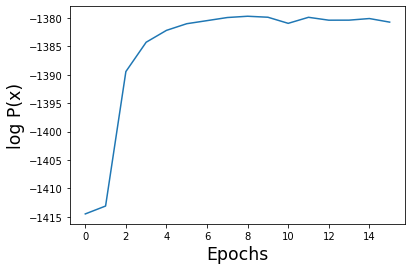

In [10]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots()
ax.set_ylabel('log P(x)', fontsize='xx-large')
ax.set_xlabel('Epochs', fontsize='xx-large')
plt.plot(get_loss_vs_time())
plt.show()